In [1]:
#Import necessary libraries
import pandas as pd
import sqlite3
import os
import matplotlib.pyplot as plt
import geopandas as gpd


In [2]:
import sys
print(sys.executable)

c:\Users\13124\AppData\Local\Programs\Python\Python313\python.exe


In [3]:
#Load Airbnb Listings 
nyc_airbnb_listings = pd.read_csv('listings.csv')

In [4]:
#Load Airbnb Reviews 
nyc_airbnb_reviews = pd.read_csv('reviews.csv')

In [5]:
#Load Airbnb Reviews
nyc_rent_prices = pd.read_csv('Zip_zori_uc_sfrcondomfr_sm_month.csv')

DATA CLEANING

In [6]:

#Separating the date columns from the non-date columns in the rent prices DataFrame.
cols = nyc_rent_prices.columns
usable_cols = cols[0:9]
dates_cols = cols[9:]
print(dates_cols) 

Index(['2015-01-31', '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
       '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
       ...
       '2025-02-28', '2025-03-31', '2025-04-30', '2025-05-31', '2025-06-30',
       '2025-07-31', '2025-08-31', '2025-09-30', '2025-10-31', '2025-11-30'],
      dtype='object', length=131)


In [7]:
#Melting the rent prices DataFrame to transform it from wide format to long format.
nyc_rent_prices = pd.melt(nyc_rent_prices, id_vars=usable_cols, value_vars=dates_cols, var_name='date', value_name='rent_price')                    

In [8]:
#Checking the data types of each column in the rent prices DataFrame. Date column is an object format and needs to be converted to a datetime format.
nyc_rent_prices.dtypes

RegionID        int64
SizeRank        int64
RegionName      int64
RegionType     object
StateName      object
State          object
City           object
Metro          object
CountyName     object
date           object
rent_price    float64
dtype: object

In [9]:
#Reformat as datetime

nyc_rent_prices['date'] = pd.to_datetime(nyc_rent_prices['date'], format = '%Y-%m-%d')

#Keep only year and month in date column

nyc_rent_prices['date'] = nyc_rent_prices['date'].dt.to_period('M')

In [10]:
#Chaning the date column in the reviews DataFrame to a datetime format.

nyc_airbnb_reviews['date'] = pd.to_datetime(nyc_airbnb_reviews['date'], format = '%Y-%m-%d')

#Keep only year and month in date column

nyc_airbnb_reviews['date'] = nyc_airbnb_reviews['date'].dt.to_period('M')


In [14]:


#Group by month and count
# 'date' is already period[M], group directly by it to avoid .dt.to_period linting error
monthly_counts = nyc_airbnb_reviews.groupby('date').size()
print(monthly_counts)


date
2009-05        1
2009-06        2
2009-07        3
2009-08        4
2009-10        7
           ...  
2025-08    13618
2025-09    14133
2025-10    14050
2025-11    11446
2025-12      557
Freq: M, Length: 199, dtype: int64


<Figure size 1200x600 with 0 Axes>

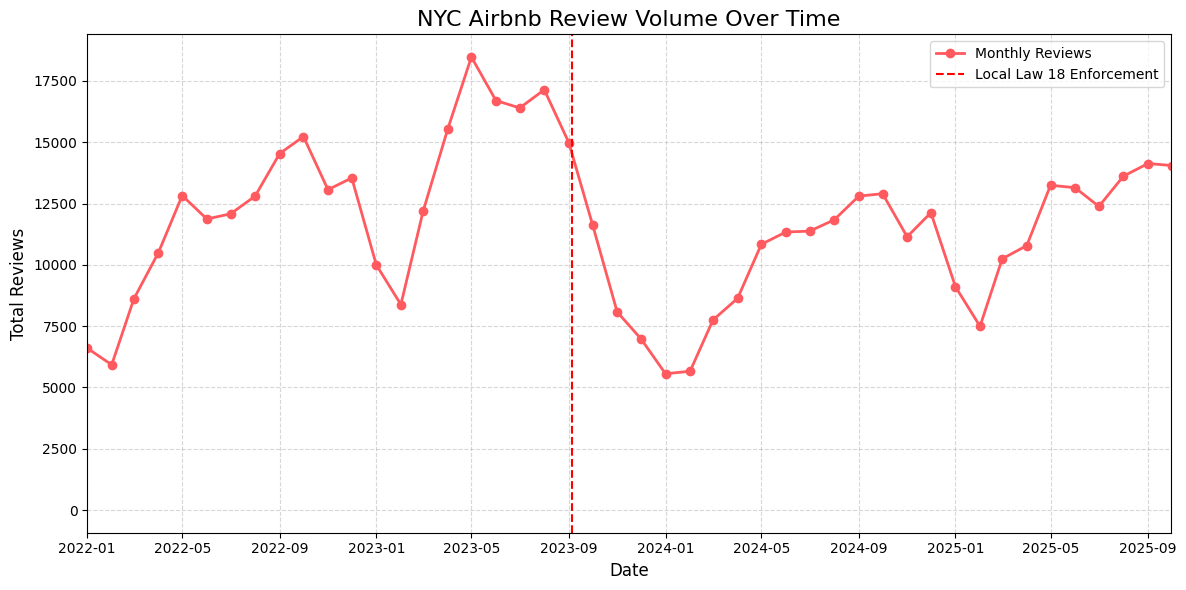

In [15]:
plt.figure(figsize=(12, 6))

x_values = monthly_counts.index
y_values = monthly_counts.values

if isinstance(monthly_counts.index, pd.PeriodIndex):
    x_values = x_values.to_timestamp()

plt.figure(figsize=(12, 6))
plt.plot(x_values, 
         y_values, 
         marker='o', 
         color='#FF5A5F',  # Airbnb Red
         linewidth=2,
         label='Monthly Reviews')

# Set x-axis limits to 2022-01-01 to 2025-09-30
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2025-09-30'))

plt.axvline(pd.Timestamp('2023-09-05'), color='red', linestyle='--', label='Local Law 18 Enforcement')

# 5. Labels and Titles
plt.title("NYC Airbnb Review Volume Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Reviews", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# 6. Show it
plt.tight_layout()
plt.show()

In [16]:
print(monthly_counts.dtypes)



int64


In [17]:
df_style = monthly_counts.to_frame(name='Review Count')

if isinstance(df_style.index, pd.PeriodIndex):
    septembers = df_style[df_style.index.month == 9].copy()
else:
    septembers = df_style[df_style.index.month == 9].copy()

septembers['Change'] = septembers['Review Count'].diff() # The raw number drop
septembers['% Change'] = septembers['Review Count'].pct_change() # The percentage drop

styled_table = (septembers.style
    .format({
        'Review Count': '{:,.0f}',    # Comma for thousands (e.g. 15,000)
        'Change': '{:+,.0f}',         # Force +/- sign (e.g. -500)
        '% Change': '{:+.1%}'         # Percentage format (e.g. -15.5%)
    })
    .text_gradient(cmap='RdYlGn', subset=['% Change'], vmin=-0.5, vmax=0.5) # Color scale
    .set_caption("Year-Over-Year Review Changes (September Only)")
    .set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center')]}
    ])
)

# 5. Display
styled_table

,Review Count,Change,% Change
date,,,
2010-09,73,+nan,+nan%
2011-09,250,+177,+242.5%
2012-09,392,+142,+56.8%
2013-09,759,+367,+93.6%
2014-09,"1,454",+695,+91.6%
2015-09,"3,131","+1,677",+115.3%
2016-09,"4,953","+1,822",+58.2%
2017-09,"6,623","+1,670",+33.7%
2018-09,"8,641","+2,018",+30.5%


Index([':id', ':version', ':created_at', ':updated_at', 'modzcta', 'label',
       'zcta', 'pop_est', 'geometry'],
      dtype='object')
                  :id           :version                      :created_at  \
0  row-gpt4_p42m_6vva  rv-ifsq~eg4w~ai57 2020-05-13 23:28:10.857000+00:00   
1  row-bbrn_fnac~4g99  rv-hpz3~wiyn~m6gy 2020-05-13 23:28:10.857000+00:00   
2  row-biyt~mhqy-petn  rv-gkuq_5peu.nhnh 2020-05-13 23:28:10.857000+00:00   
3  row-ybyu_gysg-cn9b  rv-mn4n.y64c-dt8w 2020-05-13 23:28:10.857000+00:00   
4  row-5tvi_hb3c-6qz6  rv-m2qf-b3bm.h8vn 2020-05-13 23:28:10.857000+00:00   

                       :updated_at modzcta         label                 zcta  \
0 2020-05-13 23:28:10.857000+00:00   10001  10001, 10118  10001, 10119, 10199   
1 2020-05-13 23:28:10.857000+00:00   10002         10002                10002   
2 2020-05-13 23:28:10.857000+00:00   10003         10003                10003   
3 2020-05-13 23:28:10.857000+00:00   10026         10026                1002

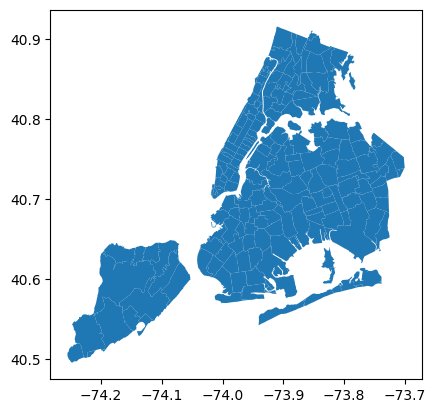

In [18]:
nyc_map = gpd.read_file("nyc_zip_geo.geojson")

nyc_map.plot()
print(nyc_map.columns)
print(nyc_map.head())

In [19]:
#Create GeoDataFrame for Airbnb listings
airbnb_gdf = gpd.GeoDataFrame(
    nyc_airbnb_listings, 
    geometry=gpd.points_from_xy(nyc_airbnb_listings.longitude, nyc_airbnb_listings.latitude),
    crs="EPSG:4326"  
)

In [20]:
#Convert Airbnb GeoDataFrame to match NYC map CRS
airbnb_gdf = airbnb_gdf.to_crs(nyc_map.crs)

In [21]:
joined_data = gpd.sjoin(airbnb_gdf, nyc_map, how="left", predicate="within")

joined_data['label'] = joined_data['label'].astype(str).str.split(',').str[0]

joined_data['label'] = joined_data['label'].str.strip()
print(joined_data['label'].unique())

['11218' '10018' '11211' '10035' '10029' '11201' '10003' '10027' '10030'
 '10009' '10025' '10026' '11222' '10475' '11221' '10019' '11238' '11226'
 '11216' '11206' '11231' '11103' '11101' '10012' '10011' '11205' '10024'
 '10013' '10023' '11102' '10002' '10075' '10010' '10031' '10001' '10040'
 '11215' '10128' '11693' '10014' '11234' '11233' '11217' '11104' '10039'
 '11385' '10454' '11207' '10028' '11105' '11379' '11223' '11434' '10036'
 '11225' '10032' '' '10021' '11235' '10314' '11209' '11204' '11203'
 '10065' '10305' '11374' '11213' '10017' '11237' '11377' '10034' '10468'
 '10033' '11220' '11378' '11229' '10463' '11373' '11435' '10016' '11208'
 '11372' '10280' '10307' '10304' '11232' '11370' '10007' '11356' '11106'
 '10469' '11361' '11230' '11355' '10451' '10464' '11692' '11418' '10455'
 '10037' '11428' '10022' '10069' '11236' '10467' '10473' '10460' '11210'
 '10038' '10006' '10462' '10005' '11224' '11214' '10471' '11360' '11417'
 '11109' '11357' '11354' '10282' '11421' '10004' '10312'

In [22]:
print(joined_data[['id', 'label']].head())

     id  label
0  2539  11218
1  2595  10018
2  6848  11211
3  6872  10035
4  6990  10029


In [23]:
zip_counts_dec_2025 = joined_data['label'].value_counts().reset_index()
nyc_density_map_dec_2025 = nyc_map.merge(zip_counts_dec_2025, on='label', how='left')

nyc_density_map_dec_2025['count'] = nyc_density_map_dec_2025['count'].fillna(0)

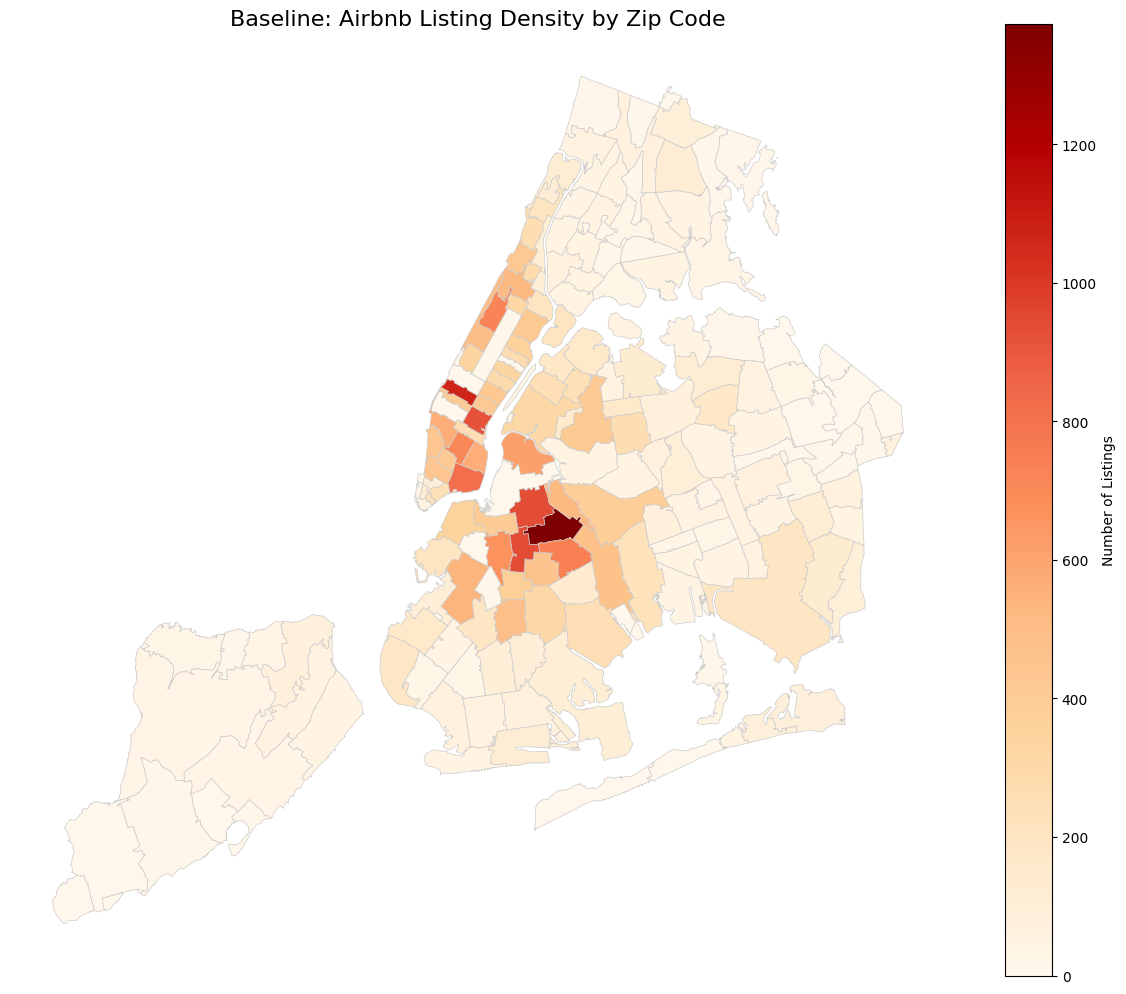

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))
nyc_density_map_dec_2025.plot(
    column='count',
    cmap='OrRd',           # 'OrRd' = Orange to Red (Red is "Hot")
    linewidth=0.5,
    ax=ax,
    edgecolor='0.8',       # Light grey border for shapes
    legend=True,           # Show the color bar
    legend_kwds={'label': "Number of Listings"}
)

plt.title("Baseline: Airbnb Listing Density by Zip Code", fontsize=16)
plt.axis('off') # Turn off the ugly lat/lon box
plt.tight_layout()
plt.show()

In [25]:
zip_lookup = joined_data[['id', 'label']].drop_duplicates()

nyc_airbnb_reviews = nyc_airbnb_reviews.merge(
    zip_lookup, 
    left_on='listing_id', 
    right_on='id', 
    how='left'
)

In [26]:
#Define pre- and post-law periods

pre_start = pd.Period('2023-05', freq='M')
pre_end   = pd.Period('2023-08', freq='M')

post_start = pd.Period('2024-05', freq='M')
post_end   = pd.Period('2024-08', freq='M')

In [27]:
#Filter reviews for pre- and post-law periods
pre_reviews = nyc_airbnb_reviews[
    (nyc_airbnb_reviews['date'] >= pre_start) & 
    (nyc_airbnb_reviews['date'] <= pre_end)
]

post_reviews = nyc_airbnb_reviews[
    (nyc_airbnb_reviews['date'] >= post_start) & 
    (nyc_airbnb_reviews['date'] <= post_end)
]

In [28]:
#Count reviews per listing in pre- and post-law periods
pre_counts = pre_reviews['listing_id'].value_counts().reset_index()
pre_counts.columns = ['id', 'pre_count']

post_counts = post_reviews['listing_id'].value_counts().reset_index()
post_counts.columns = ['id', 'post_count']

In [31]:
analysis_df = joined_data[['id', 'label']].drop_duplicates().copy()

analysis_df = analysis_df.merge(pre_counts, on='id', how='left')
analysis_df = analysis_df.merge(post_counts, on='id', how='left')

In [30]:
joined_data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,geometry,index_right,:id,:version,:created_at,:updated_at,modzcta,label,zcta,pop_est
0,2539,https://www.airbnb.com/rooms/2539,20251204025441,2025-12-06,previous scrape,Superfast Wi-Fi. Clean & quiet home by the park,"Bright, serene room in a renovated apartment h...",Close to Prospect Park and Historic Ditmas Park,https://a0.muscache.com/pictures/hosting/Hosti...,2787,...,POINT (-73.97238 40.64529),101.0,row-awuh~4z2b_27uk,rv-68dj~qu3r-ijck,2020-05-13 23:28:10.857000+00:00,2020-05-13 23:28:10.857000+00:00,11218,11218,11218,74508
1,2595,https://www.airbnb.com/rooms/2595,20251204025441,2025-12-05,city scrape,Skylit Studio Oasis | Midtown Manhattan Sanctuary,Prime Midtown | Spacious 500 Sq Ft | Pyramid S...,Centrally located in the heart of Manhattan ju...,https://a0.muscache.com/pictures/hosting/Hosti...,2845,...,POINT (-73.98559 40.75356),16.0,row-gvg2.5r6m-efd9,rv-wj6m-6fj9-tt3b,2020-05-13 23:28:10.857000+00:00,2020-05-13 23:28:10.857000+00:00,10018,10018,10018,9687
2,6848,https://www.airbnb.com/rooms/6848,20251204025441,2025-12-04,city scrape,Only 2 stops to Manhattan studio,Comfortable studio apartment with super comfor...,NaN,https://a0.muscache.com/pictures/e4f031a7-f146...,15991,...,POINT (-73.95342 40.70935),98.0,row-4dsg_smqi-75gu,rv-2vxw~x4wg~v2da,2020-05-13 23:28:10.857000+00:00,2020-05-13 23:28:10.857000+00:00,11211,11211,11211,102624
3,6872,https://www.airbnb.com/rooms/6872,20251204025441,2025-12-05,city scrape,Uptown Sanctuary w/ Private Bath (Month to Month),This charming distancing-friendly month-to-mon...,This sweet Harlem sanctuary is a 10-20 minute ...,https://a0.muscache.com/pictures/miso/Hosting-...,16104,...,POINT (-73.94255 40.80107),32.0,row-8rr6-5g74_satm,rv-fpmf~2pz3.e6yc,2020-05-13 23:28:10.857000+00:00,2020-05-13 23:28:10.857000+00:00,10035,10035,10035,35743
4,6990,https://www.airbnb.com/rooms/6990,20251204025441,2025-12-05,city scrape,UES Beautiful Blue Room,Beautiful peaceful healthy home,"Location: Five minutes to Central Park, Museum...",https://a0.muscache.com/pictures/45fb4ec7-6856...,16800,...,POINT (-73.94759 40.78778),26.0,row-qkxk_6mpr_iexs,rv-k5bh~2jjb_4iyk,2020-05-13 23:28:10.857000+00:00,2020-05-13 23:28:10.857000+00:00,10029,10029,10029,79597


In [35]:
analysis_df = analysis_df.fillna(0)
zip_changes = analysis_df.groupby('label')[['pre_count', 'post_count']].sum().reset_index()
zip_changes = zip_changes[zip_changes['pre_count'] > 50].copy()

In [38]:
zip_changes['pct_change'] = (zip_changes['post_count'] - zip_changes['pre_count']) / zip_changes['pre_count']
zip_changes['nominal_change'] = zip_changes['post_count'] - zip_changes['pre_count']
print(zip_changes.sort_values('nominal_change', ascending=False).head(10))

    label  pre_count  post_count  pct_change  nominal_change
33  10036      914.0      1946.0    1.129103          1032.0
1   10001     2176.0      2794.0    0.284007           618.0
16  10018      351.0       890.0    1.535613           539.0
17  10019      955.0      1375.0    0.439791           420.0
14  10016      506.0       818.0    0.616601           312.0
96  11209      304.0       583.0    0.917763           279.0
35  10038       97.0       274.0    1.824742           177.0
15  10017      279.0       440.0    0.577061           161.0
9   10010      232.0       372.0    0.603448           140.0
5   10005      211.0       349.0    0.654028           138.0


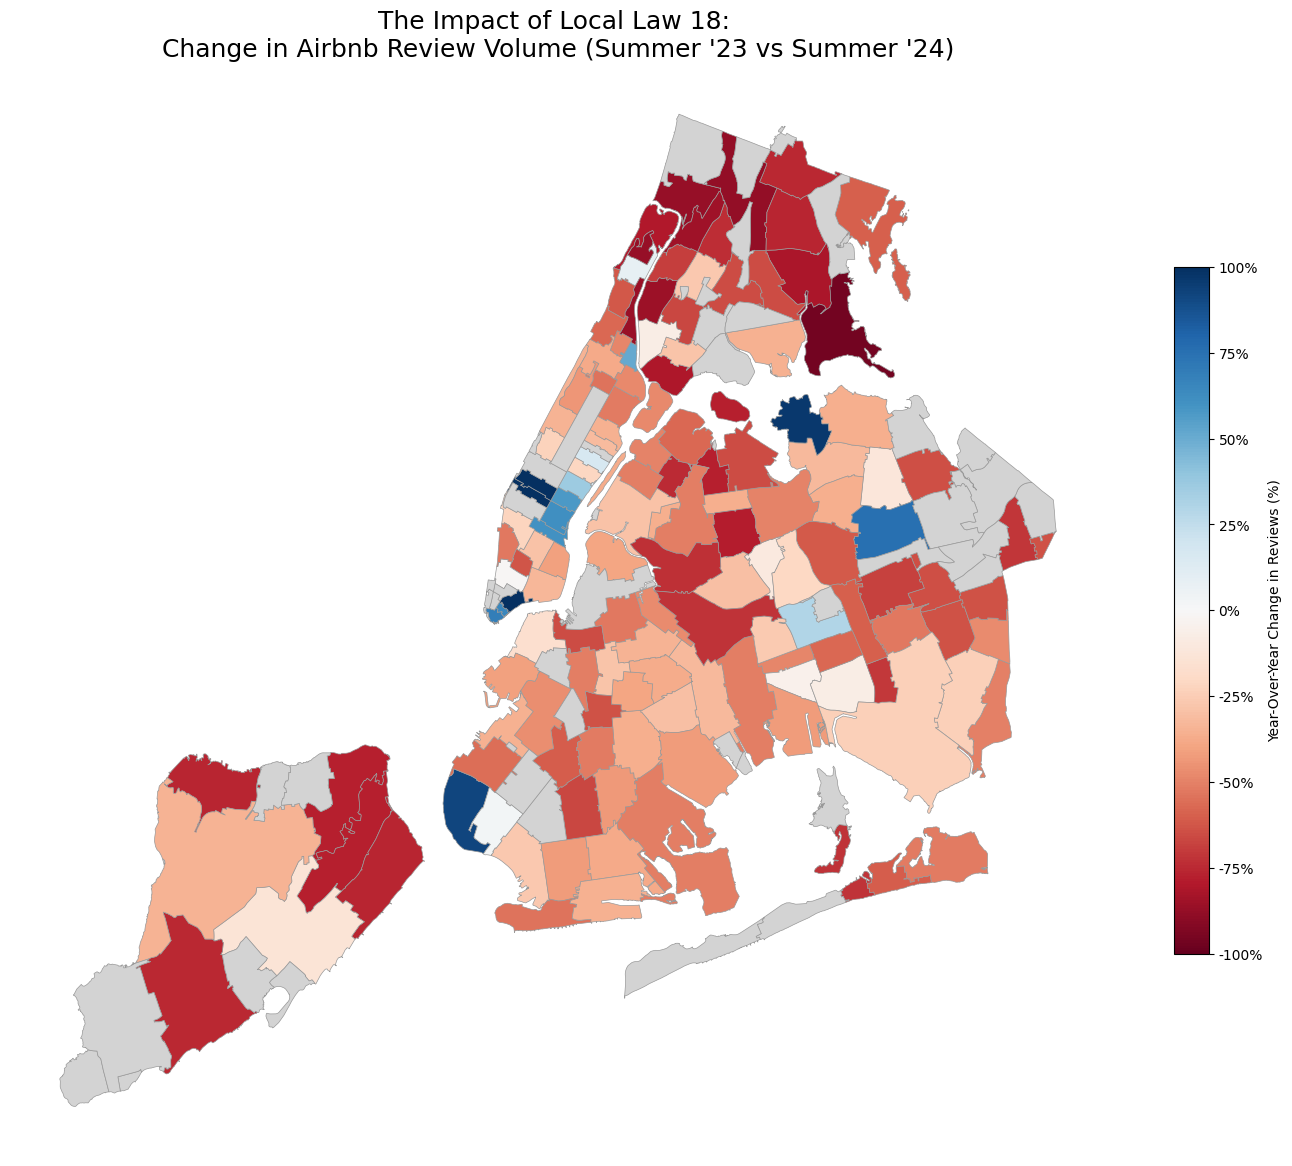

In [43]:
nyc_change_map = nyc_map.merge(zip_changes, on='label', how='left')

nyc_change_map['pct_plot'] = nyc_change_map['pct_change'] * 100

fig, ax = plt.subplots(figsize=(14, 12))

nyc_change_map.plot(
    column='pct_plot',
    cmap='RdBu',           # Red = Negative (Drop), Blue = Positive (Growth)
    linewidth=0.5,
    ax=ax,
    edgecolor='0.6',       # Subtle grey borders
    legend=True,
    legend_kwds={
        'label': "Year-Over-Year Change in Reviews (%)", 
        'shrink': 0.6,
        'format': "%.0f%%" # Format legend as percentages (e.g., -50%)
    },
    missing_kwds={
        'color': 'lightgrey', 
        'label': 'Insufficient Data'
    },
    vmin=-100,  # Lock scale at -100% (Red)
    vmax=100    # Lock scale at +100% (Blue)
)

# 4. Add Titles and Context
plt.title("The Impact of Local Law 18: \nChange in Airbnb Review Volume (Summer '23 vs Summer '24)", fontsize=18)
plt.axis('off') # Clean look (no lat/long axes)

plt.tight_layout()
plt.show()
